In [13]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow import keras
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
import os

In [14]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [15]:
def create_model():
    base_model = MobileNetV3Small(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Next, we will freeze the base model so that all the learning from the ImageNet 
    # dataset does not get destroyed in the initial training.
    base_model.trainable = False

    # Create inputs with correct shape
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)

    # Add pooling layer or flatten layer
    x =  keras.layers.GlobalAveragePooling2D()(x)

    # Add a batch normalization layer
    x = keras.layers.BatchNormalization()(x)

    # Add final dense layer with 6 classes for the 6 types of fruit
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)

    # Combine inputs and outputs to create model
    model = keras.Model(inputs, outputs)

    # uncomment the following code if you want to see the model
    return model

In [16]:
model = create_model()
# model.trainable = True
model.load_weights('C:/Users/samee/Documents/Imagine Cup Saved Models/MIMIC/14-0.9598.h5')

In [17]:
test_directory = 'C:/Users/samee/Downloads/MIMIC/Valid'

In [18]:
testdataset = keras.preprocessing.image_dataset_from_directory(
        test_directory, 
        batch_size= 32,
        image_size=(224, 224), 
        color_mode='rgb',
        label_mode='binary',
        shuffle = False,
        seed = 7
    )

Found 572 files belonging to 2 classes.


In [19]:
# Chex = model.predict(test_dataset, verbose = 1)
combined = model.predict(testdataset, verbose = 1)

18/18 [==============================] - 3s 89ms/step


In [8]:
def test_categorical(y_pred, test_dataset):
    labels = np.array([])
    for x, y in testdataset:
        labels = np.concatenate([labels, np.argmax(y.numpy(), axis = -1)])
    prediction = np.argmax(y_pred, axis = -1)
    cm = metrics.confusion_matrix(y_true = labels, y_pred = prediction)
    acc = metrics.classification_report(labels, prediction)
    return {'acc': acc, 'cm': cm}

In [ ]:
a = test_categorical(y_pred = combined, test_dataset = testdataset)

In [ ]:
a['acc']

In [20]:
def test_binary(y_pred, test_dataset):
    labels = np.array([])
    for x, y in test_dataset:
        for i in y:
            labels = np.concatenate([labels, i])
    prediction = np.round(y_pred)
    clf = metrics.classification_report(labels, prediction)
    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(labels, prediction)
    prec = metrics.precision_score(labels, prediction)
    rec = metrics.recall_score(labels, prediction)
    f1 = metrics.f1_score(labels, prediction)
    kappa = metrics.cohen_kappa_score(labels, prediction)

    # Calculate area under curve (AUC)
    y_pred_proba = y_pred.ravel()
    fpr, tpr, _ = metrics.roc_curve(labels, y_pred_proba)
    auc = metrics.roc_auc_score(labels, y_pred_proba)

    # Display confusion matrix
    cm = metrics.confusion_matrix(labels, prediction)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 'cm': cm, 'clf': clf, 'auc': auc, 'fpr': fpr, 'tpr': tpr}

In [21]:
a = test_binary(y_pred = combined, test_dataset = testdataset)

In [22]:
print(a['clf'])

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       286
         1.0       0.99      0.93      0.96       286

    accuracy                           0.96       572
   macro avg       0.96      0.96      0.96       572
weighted avg       0.96      0.96      0.96       572



In [23]:
a['acc']

0.9597902097902098

In [24]:
a['auc']

0.9821629419531518

In [25]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


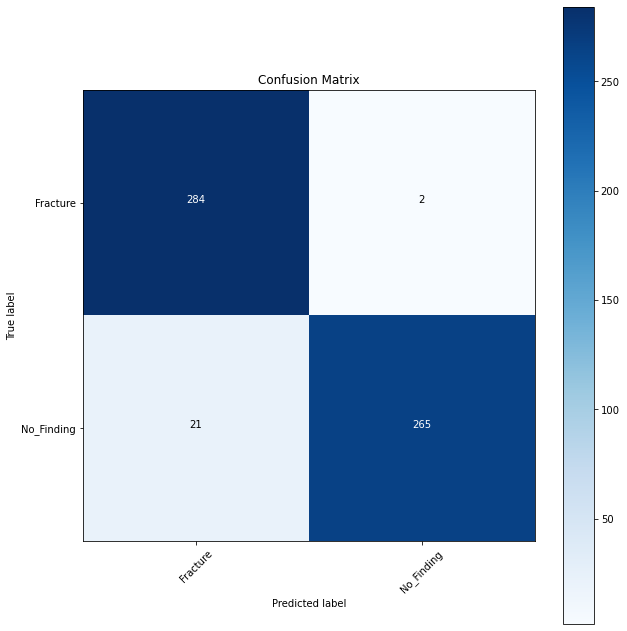

In [26]:
folders = os.listdir(test_directory)
plt.rcParams['figure.figsize'] = [9, 9]
plot_confusion_matrix(a['cm'], title = 'Confusion Matrix', classes = folders, normalize = False)